# Visualization of the trained model

In [5]:
import sys
from utils.utils import *
from utils.visualizations import *
import matplotlib.pyplot as plt
import torchvision.transforms as T

**Important**: If you get the error that references the module `SRC.models.models`, then run the following lines of code to add the explicit path to the folder SRC.

In [4]:
# Only run if necessary
full_path_to_SRC = 'C:/Users/donai/Documents/MyDocs/Universitat/Tercer curs/Semestre 2/Xarxes Neuronals i Aprenentatge Profund/Exercicis/xnap-project-matcad_grup_10'
sys.path.append(full_path_to_SRC)

## Loading the model

**Important**: Change the following paths to match the location where your data is stored.

In [6]:
DATA_LOCATION = '../data'
model_path = DATA_LOCATION + '/logs/EncoderDecorder_model.pth'
device = 'cpu' # or 'cuda:0'

In [7]:
model = load_ED_model(model_path, device)

## Visualizing the saved image and caption for a certain epoch

In [8]:
caption = joblib.load(DATA_LOCATION + '/logs/Captions/caps_epoch_25.joblib')
image = joblib.load(DATA_LOCATION + '/logs/Images/img_epoch_25.joblib')

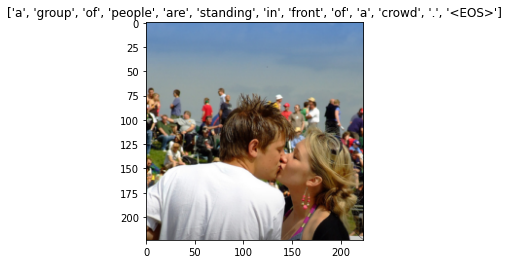

In [9]:
show_image(image, caption)

## Feeding the model other images from the test dataset

First we have to load the dataset.

In [17]:
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

config = dict(
    root_dir=DATA_LOCATION+"/Images",
    captions_file=DATA_LOCATION+"/captions.txt",
    device=device,
    encoder='ResNet50',
    transforms=transforms,
    embed_size=300,
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512,
    epochs=25,
    learning_rate=3e-4,
    batch_size=int(256),
    DATA_LOCATION=DATA_LOCATION,
    train_size=0.8,
    save=True
)

def make_dataset(config):
    dataset = joblib.load(config['DATA_LOCATION'] + "/processed_dataset.joblib")
    dataset.spacy_eng = spacy.load("en_core_web_sm")
    return dataset

def make_dataloaders(config, dataset, num_workers):
    train_dataset, test_dataset = flickr_train_test_split(dataset, config['train_size'])

    train_loader = get_data_loader(train_dataset, batch_size=config['batch_size'], num_workers=num_workers)
    test_loader = get_data_loader(test_dataset, batch_size = 5, num_workers=num_workers)

    return train_loader, test_loader

In [18]:
dataset = make_dataset(config)
vocab = dataset.vocab
train_loader, test_loader = make_dataloaders(config, dataset, 1)
model.decoder.device = 'cpu'

Now we can show the images with the predicted captions and the real captions.

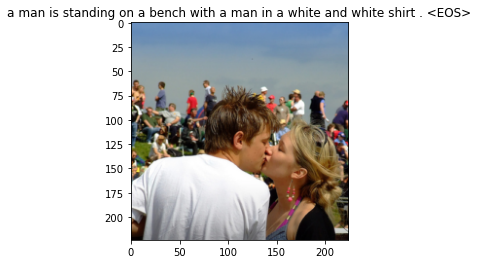

REAL CAPTIONS:

['a', 'young', 'couple', 'kiss', 'while', 'a', 'crowd', '<UNK>', 'in', 'the', 'background', 'on', 'a', 'sunny', 'day', '.', '<EOS>']
['two', 'people', 'kiss', 'near', 'a', 'crowd', '.', '<EOS>']
['a', 'man', 'is', 'kissing', 'a', 'woman', '.', '<EOS>']
['a', 'man', 'and', 'a', 'woman', 'kissing', '.', '<EOS>']
['a', 'man', 'and', 'woman', 'kissing', 'in', 'front', 'of', 'a', 'crowd', 'of', 'people', '.', '<EOS>']


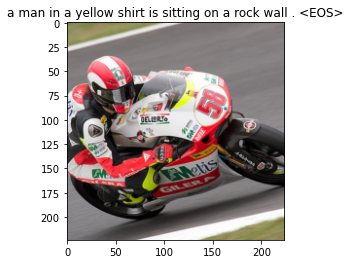

REAL CAPTIONS:

['a', 'man', 'racing', 'on', 'a', 'motorbike', '<EOS>']
['a', 'motorcycle', 'rider', 'drives', 'fast', 'around', 'a', 'curve', 'on', 'a', 'track', '.', '<EOS>']
['a', 'person', 'wearing', 'a', 'red', 'and', 'white', 'uniform', 'is', 'racing', 'a', 'motorcycle', 'with', 'the', 'number', '<UNK>', 'on', 'it', '.', '<EOS>']
['a', 'red', 'and', 'white', 'motorcycle', 'is', 'being', 'ridden', 'around', 'a', 'bend', 'on', 'a', 'racetrack', '.', '<EOS>']
['red', 'and', 'white', 'motorbike', 'number', '<UNK>', 'races', 'around', 'the', 'track', '.', '<EOS>']


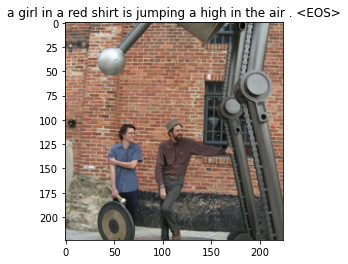

REAL CAPTIONS:

['two', 'men', 'standing', 'near', 'a', 'metal', 'structure', 'in', 'from', 'of', 'a', 'brick', 'wall', '.', '<EOS>']
['two', 'men', 'standing', 'at', 'the', 'feet', 'of', 'a', 'large', 'sculpture', '.', '<EOS>']
['two', 'men', 'are', 'standing', 'under', 'what', 'looks', 'to', 'be', 'a', 'giant', 'robot', '.', '<EOS>']
['a', 'man', 'leans', 'against', 'a', 'large', 'robot', '.', '<EOS>']
['two', 'men', 'are', 'standing', 'under', 'a', 'large', 'work', 'of', 'art', 'by', 'a', 'brick', 'building', '.', '<EOS>']


In [37]:
# Number of images to show
num_show = 3

# Showing the images
test_loader_showing = deepcopy(test_loader)
with torch.no_grad():
    dataiter = iter(test_loader_showing)
    for i in range(num_show):    
            img, real_captions = next(dataiter)
            features = model.encoder(img[0:1].to(device))
            caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
            caption = ' '.join(caps)
            show_image(img[2], caption)
            print("REAL CAPTIONS:\n")
            for i in range(len(real_captions)):
                print(dataset.vocab.get_caption(real_captions[i].tolist()))

## Feeding the model a custom image

In [88]:
# Path to the custom image
img_location = DATA_LOCATION + '/Custom/us3.png' 

# Transforming the image to the correct format
img = Image.open(img_location)
img = img.convert("RGB")
img = transforms(img)
img = img.unsqueeze(0)

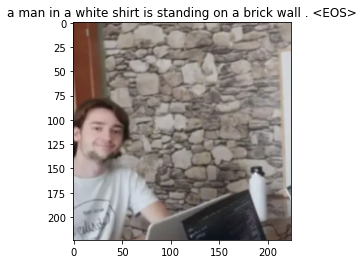

In [89]:
# Feeding the model the image
features = model.encoder(img.to(device))
caps, alphas = model.decoder.generate_caption(features, vocab=vocab)

# Showing the caption and the image
caption = ' '.join(caps)
show_image(img[0], caption)

## Visualizing the attention for a certain image

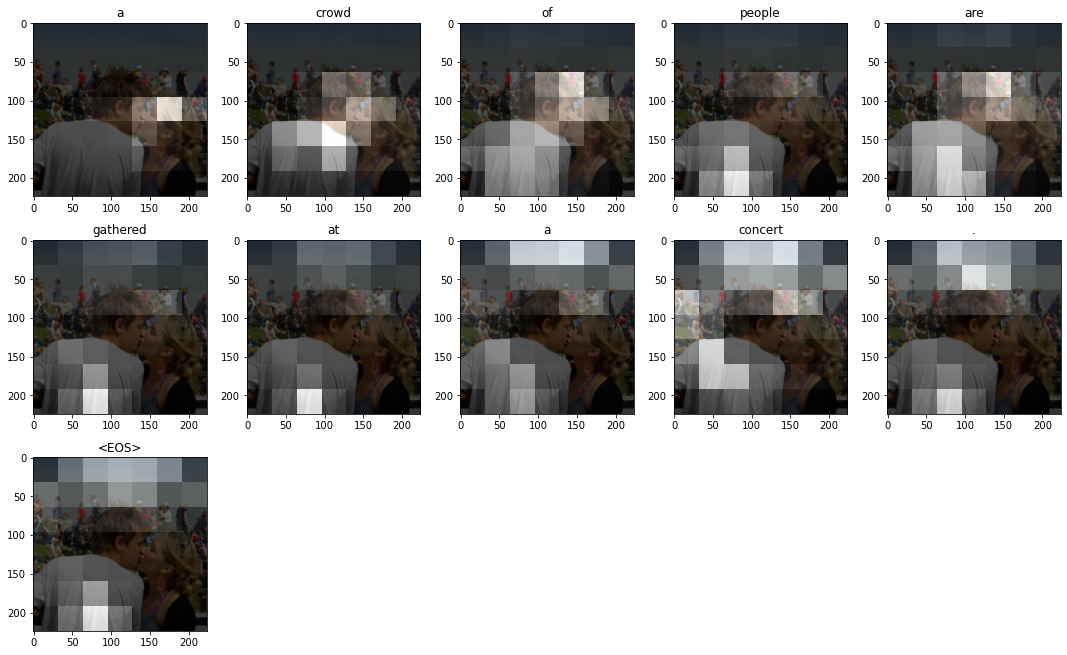

In [71]:
test_loader_showing = deepcopy(test_loader)
dataiter = iter(test_loader_showing)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(model, img.unsqueeze(0), vocab, device)

plot_attention(img1, caps, alphas)